# Importing libraries


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.metrics import classification_report, confusion_matrix

# Data Preprocessing

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


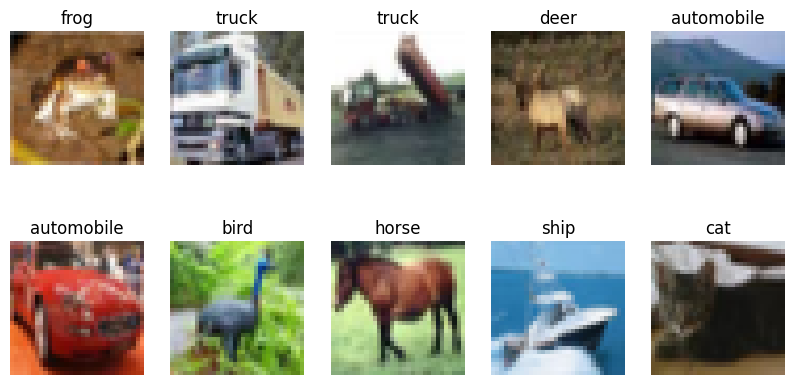

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display some sample images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.show()

In [3]:
print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


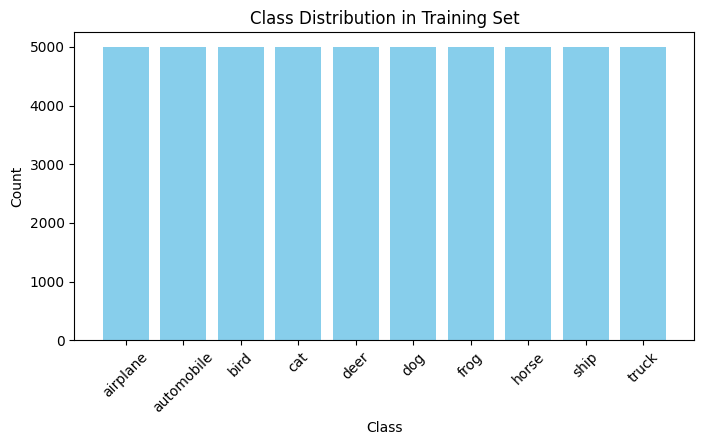

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert images to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

# Data Augmentation (Improved)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2  # Splitting into train (80%) and validation (20%)
)

# Create train and validation generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=64, subset='training')
val_generator = train_datagen.flow(x_train, y_train, batch_size=64, subset='validation')

# Convert test set to TensorFlow dataset format
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

# Define ResNet-18 Model with Transfer Learning

In [6]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [10]:
#pip install --upgrade tensorflow -q


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-30:]:  # Fine-tune last 10 layers
    layer.trainable = True

# Add custom layers for CIFAR-10 classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)  # Adding dropout for better generalization
out = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=out)

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [13]:
# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

In [14]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
# history = model.fit(train_generator, 
#                     validation_data=val_generator, 
#                     epochs=50, 
#                     callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1334 - loss: 3.4755

In [9]:
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=50, 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 63ms/step - accuracy: 0.2933 - loss: 2.3471 - val_accuracy: 0.1026 - val_loss: 5.9808 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.5668 - loss: 1.2608 - val_accuracy: 0.6429 - val_loss: 1.0213 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.6440 - loss: 1.0477 - val_accuracy: 0.6961 - val_loss: 0.8809 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.6797 - loss: 0.9380 - val_accuracy: 0.7111 - val_loss: 0.8391 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7047 - loss: 0.8622 - val_accuracy: 0.7123 - val_loss: 0.8395 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.7242 - loss: 0.7986 - val_accuracy: 0.7379 - val_loss: 0.7756 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accurac

# Evaluate the Model (Metrics & Confusion Matrix)

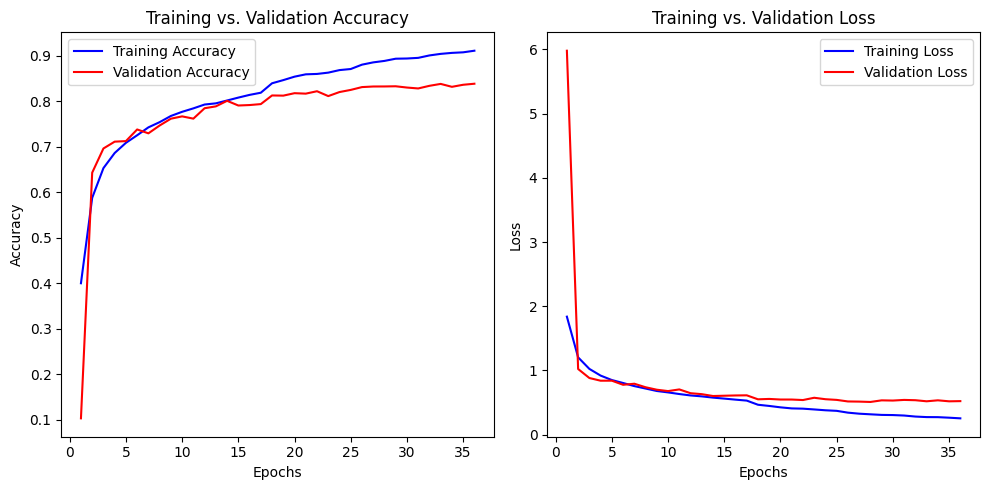

In [10]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from training history
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
y_pred = np.argmax(model.predict(x_test), axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
              precision    recall  f1-score   support

    airplane       0.90      0.87      0.88      1000
  automobile       0.87      0.94      0.91      1000
        bird       0.82      0.84      0.83      1000
         cat       0.75      0.68      0.71      1000
        deer       0.84      0.81      0.83      1000
         dog       0.84      0.72      0.77      1000
        frog       0.80      0.94      0.86      1000
       horse       0.88      0.90      0.89      1000
        ship       0.93      0.90      0.91      1000
       truck       0.87      0.90      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



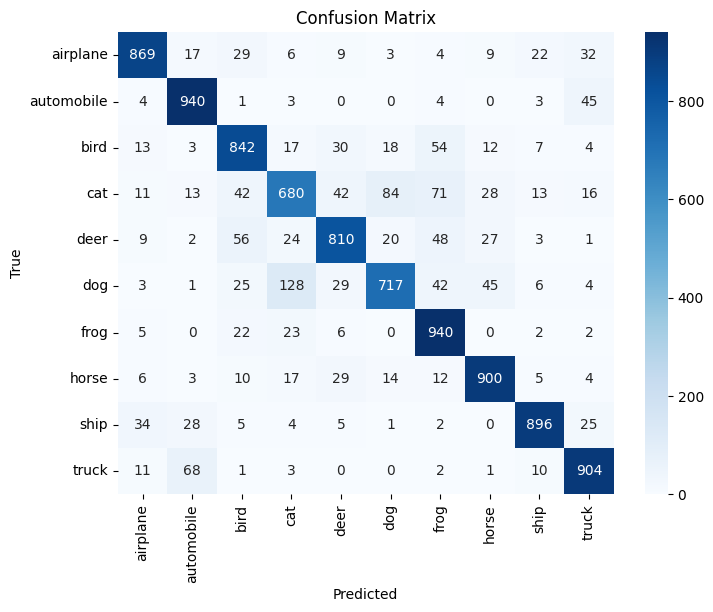

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Save the trained model
model.save("resnet50_cifar10.h5")
model.save("resnet50_cifar10.keras")

print("Model training complete! Model saved as 'resnet50_cifar10'.")

Model training complete! Model saved as 'resnet50_cifar10'.
